In [1]:
# Read NetworkX package
# https://networkx.org/documentation/stable/index.html
import networkx as nx
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_comm
import seaborn as sns

colors={
    'b':'#4285F4',
    'r':'#DB4437',
    'y':'#F4B400',
    'g':'#0F9D58',
    'gray':'#D3D3D3',
    'purple':'#550a8a'
}

In [2]:
df_policy_has_pa_scholarly=pd.read_pickle('./sample_dta/df_policy_has_pa_scholarly_sample.pkl.bz2')

In [25]:
df_policy_has_pa_scholarly[df_policy_has_pa_scholarly.policy_document_id=='unhabitat-aacd7392b9a36e5a7a9278a0ce829072']

,policy_document_id,scholarly_doi
1205740,unhabitat-aacd7392b9a36e5a7a9278a0ce829072,10.1111/j.1467-9299.2009.01753.x
1205803,unhabitat-aacd7392b9a36e5a7a9278a0ce829072,10.1111/j.1468-0491.2007.00365.x


In [22]:
df_policy_has_pa_scholarly

,policy_document_id,scholarly_doi
994323,diwde-97c59ee8ee27d4e50bc309e80aead0bd,10.1017/s0047279415000525
546031,ceps-655e372a279376c2b3a3921d30423789,10.17645/pag.v4i3.598
1398501,oecddiscovery-b09936c523a47c9779d2288a213ce30c,10.1108/jea-06-2016-0064
1781122,technopolis-4ee6d975a6e5ed30f19456ef35b65d45,10.3152/147154303781780308
1058000,odi-318ca2a35677e5ba31c4e6749c0767e9,10.1017/gov.2015.7
...,...,...
1010381,esridublin-f8a973720d30eb459704863e6f6b885a,10.1017/s004727941800079x
1205803,unhabitat-aacd7392b9a36e5a7a9278a0ce829072,10.1111/j.1468-0491.2007.00365.x
1001584,who-64559ffba90c4bbb1559ce4287aff53d,10.1017/s0047279416000623
415640,imf-dc62ec5d75076b51587a066cf12dfefa,10.1177/1091142108316588


# Network Construction

In [4]:
# Create bipartite graph.
# https://networkx.org/documentation/stable/reference/algorithms/bipartite.html
# https://en.wikipedia.org/wiki/Bipartite_graph
g_policy_scholarly=nx.Graph() # Define graph
g_policy_scholarly.add_nodes_from(df_policy_has_pa_scholarly.policy_document_id, bipartite='policy_document_id') # Add first set of nodes and label.
g_policy_scholarly.add_nodes_from(df_policy_has_pa_scholarly.scholarly_doi, bipartite='scholarly_doi') # Add second set of nodes and label.
g_policy_scholarly.add_edges_from(df_policy_has_pa_scholarly[['policy_document_id','scholarly_doi']].values) # Add edges

In [6]:
# Project to only article network, i.e., co-occurrence/co-citation network. 
# https://en.wikipedia.org/wiki/Co-occurrence_network
# https://en.wikipedia.org/wiki/Co-citation
from networkx.algorithms import bipartite
g_scholarly=bipartite.weighted_projected_graph(g_policy_scholarly, df_policy_has_pa_scholarly.scholarly_doi)

In [10]:
pd.DataFrame(g_scholarly.edges(data=True))

,0,1,2
0,10.1017/s0047279415000525,10.1177/1091142113506931,{'weight': 1}
1,10.1017/s0047279415000525,10.1017/s0047279413000974,{'weight': 1}
2,10.1017/s0047279415000525,10.1017/s0047279416000647,{'weight': 1}
3,10.1017/s0047279415000525,10.1080/13501763.2017.1363269,{'weight': 1}
4,10.1017/s0047279415000525,10.1332/175982716x14721954315048,{'weight': 2}
...,...,...,...
39675,10.1177/0275074018799490,10.1177/0020852318823913,{'weight': 1}
39676,10.1111/ropr.12187,10.1080/13501763.2019.1617334,{'weight': 1}
39677,10.2307/977392,10.1177/027507409402400402,{'weight': 1}
39678,10.3152/030234209x406809,10.3152/030234209x413919,{'weight': 1}


In [11]:
# The network contains too many nodes for analysis. 
len(g_scholarly)

15746

#   Network Pruning and Visualization

In [12]:
# Network pruning using k-core. Let's try different Ks.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.k_core.html
# Another approach commonly employed is removing isolated nodes.

node_comm_nums=[]
for k in tqdm(range(0, 20, 1)):
    g_scholarly_k=nx.k_core(g_scholarly, k=k)
    lv_comm_tmp=nx_comm.louvain_communities(g_scholarly_k, weight='weight', resolution=1, threshold=1e-07, seed=512)
    node_comm_nums+=[[k, len(g_scholarly_k), len(lv_comm_tmp)]]

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
df_k_test=pd.DataFrame(node_comm_nums).rename(columns={0:'k', 1:'#Article', 2:'#Cluster'})
df_k_test

,k,#Article,#Cluster
0,0,15746,6574
1,1,10135,966
2,2,7371,273
3,3,5636,112
4,4,4513,78
5,5,3678,64
6,6,3117,55
7,7,2705,46
8,8,2330,43
9,9,1975,40


/tmp/ipykernel_1346009/3015408536.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ylabels = ['{:,.1f}'.format(x) + 'K' for x in (ax2.get_yticks()/1000)]; ax2.set_yticklabels(ylabels)


Text(0.5, 0, '$k\\_core$')

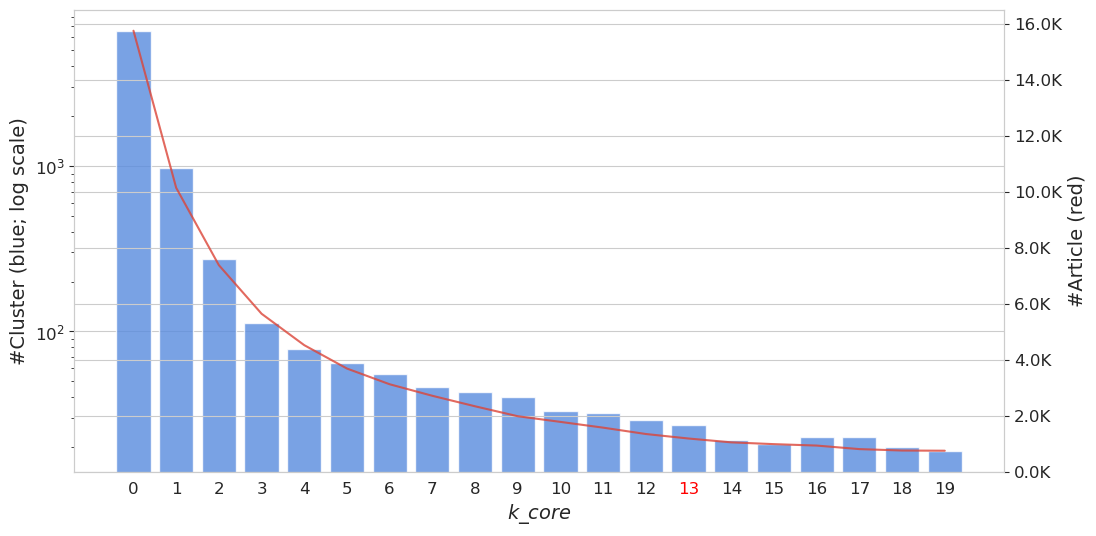

In [16]:
from matplotlib.ticker import MaxNLocator

sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(x=df_k_test.k, y=df_k_test['#Cluster'], color=colors['b'], ax=ax1, alpha=.8)
plt.xticks(fontsize=12); plt.yticks(fontsize=12); ax1.set_ylabel(ylabel='#Cluster (blue; log scale)', fontsize=14)
ax1.set_yscale('log')
ax2=ax1.twinx()

sns.lineplot(x=df_k_test.k, y=df_k_test['#Article'], color=colors['r'], ax=ax2, alpha=.8)
plt.xticks(fontsize=12); plt.yticks(fontsize=12); ax2.set_ylabel(ylabel='#Article (red)', fontsize=14)

# More formatting.
ylabels = ['{:,.1f}'.format(x) + 'K' for x in (ax2.get_yticks()/1000)]; ax2.set_yticklabels(ylabels)
ax1.get_xticklabels()[13].set_color("red")
ax1.set_xlabel(xlabel='$k\_core$', fontsize=14)

In [17]:
g_scholarly_k=nx.k_core(g_scholarly, k=13)

# Export to files
# Analyze in Gephi: https://gephi.org/
nx.write_graphml(g_scholarly_k, './g_scholarly_k.graphml')
nx.write_graphml(g_scholarly, './g_scholarly.graphml')

# Network Analysis and Visualization

In [18]:
len(g_scholarly_k)

1179

In [19]:
lv_communities=nx_comm.louvain_communities(g_scholarly, weight='weight', resolution=1, threshold=1e-07, seed=512)
lv_communities_k=nx_comm.louvain_communities(g_scholarly_k, weight='weight', resolution=1, threshold=1e-07, seed=512)
len(lv_communities), len(lv_communities_k)

(6574, 27)

In [26]:
# Network measures
deg_dict=nx.degree(g_scholarly_k)
deg_cent_dict=nx.degree_centrality(g_scholarly_k)
btw_cent_dict=nx.betweenness_centrality(g_scholarly_k, k=None, normalized=True, weight='weight', endpoints=False, seed=512)

In [32]:
# Nonnetwork measures: policy citation counts
df_policy_citation_tmp=df_policy_has_pa_scholarly.groupby('scholarly_doi').count()

In [37]:
len(nx_comm.louvain_communities(g_scholarly_k, weight='weight', resolution=1, threshold=1e-07, seed=512)
)

27

In [39]:
# Add more attributes to nodes
comm_num=1
for comm in lv_communities_k:
    for node in comm:
        g_scholarly_k.nodes[node]['policy_citation']=df_policy_citation_tmp.loc[node, 'policy_document_id']
        g_scholarly_k.nodes[node]['degree']=deg_dict[node]
        g_scholarly_k.nodes[node]['dgr_cent']=deg_cent_dict[node]
        g_scholarly_k.nodes[node]['btw_cent']=btw_cent_dict[node]
        g_scholarly_k.nodes[node]['comm_num']=comm_num
    comm_num+=1

In [40]:
list(dict(g_scholarly_k.nodes(data=True)).values())[0:5]

[{'bipartite': 'scholarly_doi',
  'policy_citation': 2,
  'degree': 22,
  'dgr_cent': 0.01867572156196944,
  'btw_cent': 2.330151640720798e-06,
  'comm_num': 22},
 {'bipartite': 'scholarly_doi',
  'policy_citation': 5,
  'degree': 18,
  'dgr_cent': 0.015280135823429542,
  'btw_cent': 0.003998265056744702,
  'comm_num': 24},
 {'bipartite': 'scholarly_doi',
  'policy_citation': 1,
  'degree': 23,
  'dgr_cent': 0.019524617996604415,
  'btw_cent': 1.554248736590761e-05,
  'comm_num': 14},
 {'bipartite': 'scholarly_doi',
  'policy_citation': 6,
  'degree': 17,
  'dgr_cent': 0.014431239388794566,
  'btw_cent': 1.2379138040613717e-05,
  'comm_num': 21},
 {'bipartite': 'scholarly_doi',
  'policy_citation': 8,
  'degree': 64,
  'dgr_cent': 0.05432937181663837,
  'btw_cent': 0.00983502459259037,
  'comm_num': 1}]

# Hypothesis Testing

In [41]:
# Reorganize the data as tidy format
df_g_scholarly_k_attr=pd.DataFrame.from_dict(dict(g_scholarly_k.nodes(data=True)), orient='index')
df_g_scholarly_k_attr

,bipartite,policy_citation,degree,dgr_cent,btw_cent,comm_num
10.1002/pam.10032,scholarly_doi,2,22,0.018676,0.000002,22
10.1017/s0143814x11000110,scholarly_doi,5,18,0.015280,0.003998,24
10.1111/puar.12993,scholarly_doi,1,23,0.019525,0.000016,14
10.1186/1478-4491-12-71,scholarly_doi,6,17,0.014431,0.000012,21
10.1007/bf00999715,scholarly_doi,8,64,0.054329,0.009835,1
...,...,...,...,...,...,...
10.1111/j.1477-7053.2004.00121.x,scholarly_doi,7,15,0.012733,0.000000,5
10.1108/tg-02-2013-0008,scholarly_doi,1,18,0.015280,0.000530,14
10.1111/0033-3352.00104,scholarly_doi,1,15,0.012733,0.000000,5
10.1002/1099-162x(200002)20:1<76::aid-pad122>3.0.co;2-8,scholarly_doi,1,15,0.012733,0.000000,5


In [42]:
# Run a simple regression
import statsmodels.formula.api as smf
mod = smf.ols(formula='policy_citation ~ scholarly_citation + degree + dgr_cent + btw_cent + C(comm_num)', data=df_g_scholarly_k_attr)
res = mod.fit(cov_type='HC0')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        policy_citation   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     7.493
Date:                Mon, 03 Apr 2023   Prob (F-statistic):           6.40e-27
Time:                        16:14:52   Log-Likelihood:                -4443.4
No. Observations:                1179   AIC:                             8945.
Df Residuals:                    1150   BIC:                             9092.
Df Model:                          28                                         
Covariance Type:                  HC0                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0315      1.30

/root/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 29, but rank is 28
  warnings.warn('covariance of constraints does not have full '


<mark>***How can you improve the anlaysis?***</mark>